### Our model must be able to overfit on the training data (i.e. get almost 100% accuracy on the training data). This notebook makes sure our model is good enough to obtain this level of performance.


In [386]:
from CpG_Net import CpGNet
from CpG_Bin import Bin
import numpy as np
import cPickle as pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from random import shuffle
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [318]:
mylist = [1,2,3]
print mylist
shuffle(mylist)
print mylist

[1, 2, 3]
[1, 3, 2]


## 1. Load data

In [2]:
data = pickle.load(open("HAMbins.p","rb"))

In [5]:
print "There are ", len(data) , " bins in the dataset"

There are  294045  bins in the dataset


## 2. Filter read depth (at least 20 reads)

In [8]:
min_read_depth = 20
read_filtered_data = [bin_ for bin_ in data if bin_.matrix.shape[0] >= min_read_depth]

In [9]:
print "There are ", len(read_filtered_data), " bins that meet the read depth requirement"

There are  275668  bins that meet the read depth requirement


## 3. Split by density

In [10]:
cpg_2_bins = [bin_ for bin_ in read_filtered_data if bin_.matrix.shape[1]==2]
cpg_3_bins = [bin_ for bin_ in read_filtered_data if bin_.matrix.shape[1]==3]
cpg_4_bins = [bin_ for bin_ in read_filtered_data if bin_.matrix.shape[1]==4]
cpg_5_bins = [bin_ for bin_ in read_filtered_data if bin_.matrix.shape[1]==5]
cpg_6_bins = [bin_ for bin_ in read_filtered_data if bin_.matrix.shape[1]==6]
cpg_7_bins = [bin_ for bin_ in read_filtered_data if bin_.matrix.shape[1]==7]
cpg_8_bins = [bin_ for bin_ in read_filtered_data if bin_.matrix.shape[1]==8]

In [424]:
# get a subset of the data to speed things up
shuffle(cpg_2_bins)
cpg_2_bins_subset = cpg_2_bins[:1000]

In [425]:
net = CpGNet(cpgDensity=2)

In [ ]:
X, y = net.collectFeatures(cpg_2_bins_subset) # extract features

  0%|          | 3/1000 [00:00<00:42, 23.48it/s]

collecting


  5%|▍         | 47/1000 [00:01<00:23, 40.43it/s]

In [401]:
# filter out negative values
nonneg = y!=-1
X_u = X[nonneg]
y_u = y[nonneg]

In [402]:
X_train, X_test, y_train, y_test = train_test_split(X_u, y_u)

(array([  76128.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  281664.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

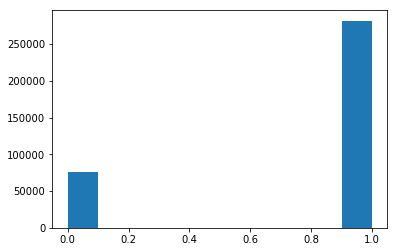

In [404]:
plt.hist(y_train)

In [407]:
print np.count_nonzero(y_test==1)/float(len(y_test))
print np.count_nonzero(y_train==1)/float(len(y_train))

0.7872870271
0.787228333781


## Preprocess (very important!)

In [408]:
X_train_scaled = preprocessing.scale(X_train)
X_test_scaled = preprocessing.scale(X_test)

In [419]:
history = net.fit(X_train_scaled, y_train, val_split=0.2, epochs=10000, batch_size=16)

Train on 286233 samples, validate on 71559 samples
Epoch 1/10000
286233/286233 [==============================] - 137s - loss: 0.3303 - acc: 0.8568 - val_loss: 0.3152 - val_acc: 0.8604
Epoch 2/10000
286233/286233 [==============================] - 135s - loss: 0.3127 - acc: 0.8622 - val_loss: 0.3119 - val_acc: 0.8594
Epoch 3/10000
 18080/286233 [>.............................] - ETA: 122s - loss: 0.3125 - acc: 0.8597

KeyboardInterrupt: 

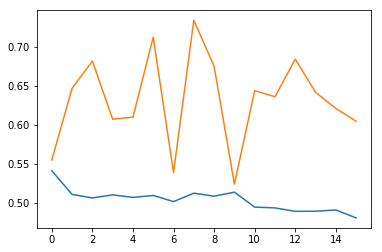

In [376]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

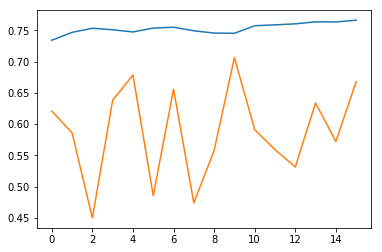

In [377]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])

In [378]:
y_pred = net.model.predict(X_big)
# y_pred_class = np.round(y_pred)


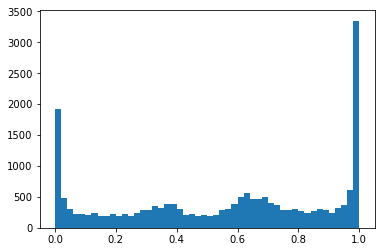

In [379]:
plt.hist(y_pred,bins=50);

(array([ 172619.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  566543.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 10 Patch objects>)

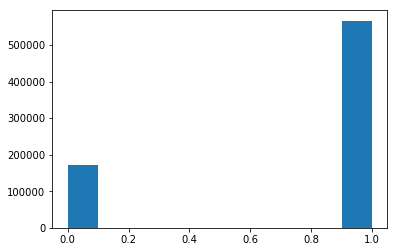

In [311]:
plt.hist(y_train)

# PCA

In [164]:
from sklearn.decomposition import PCA
#pca = PCA(n_components=X_train_u_scaled.shape[1])
pca = PCA(n_components=11)


In [165]:
pca.fit(X_train_u_scaled)

PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [166]:
print pca.explained_variance_ratio_

[ 0.25511614  0.20642283  0.13615703  0.08954821  0.08295387  0.06900115
  0.06783165  0.05922563  0.02073058  0.01193377  0.00107915]


In [167]:
X_train_u_scaled_pca = pca.transform(X_train_u_scaled)

In [168]:
X_train_u_scaled_pca.shape

(39442, 11)

In [387]:
# Logistic regression
logreg = LogisticRegression()
logreg.fit(X_big, y_big)
logreg.score(X_big,y_big)

0.75365000000000004

In [416]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [417]:
rf.score(X_test_scaled, y_test)

0.85719915481620601

In [418]:
rf.score(X_train_scaled, y_train)

0.87111506126464533